In [1]:
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, precision_score, recall_score, roc_auc_score, make_scorer, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import shap

import matplotlib.pyplot as plt

In [2]:
path_to_csv = r'/mnt/data/psteinmetz/neotex/CSV/TUMOUR.csv'
path_to_csv_ville = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_ville.csv'
path_to_csv_ozgun = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.csv'
path_to_csv_ozgun_target = r'/mnt/data/psteinmetz/neotex/CSV/Tumour_testing2.xlsx'

path_to_csv_bounding_box = r'/mnt/data/psteinmetz/neotex/CSV/BOUNDING_BOX.csv'
path_to_csv_ville_bounding_box = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_ville.csv'
path_to_bounding_box_ozgun_csv = r'/mnt/data/psteinmetz/neotex/CSV/Bounding_box_testing2.csv'

In [3]:
data_train = pd.concat((dt.fread(path_to_csv).to_pandas(), dt.fread(path_to_csv_ville).to_pandas()), ignore_index=True)
data_eval = dt.fread(path_to_csv_ozgun).to_pandas()
target_eval = pd.read_excel(path_to_csv_ozgun_target, sheet_name='Sheet2')

data_bounding_box_train = pd.concat((dt.fread(path_to_csv_bounding_box).to_pandas(), dt.fread(path_to_csv_ville_bounding_box).to_pandas()), ignore_index=True).add_prefix('bb_')
data_bounding_box_eval = dt.fread(path_to_bounding_box_ozgun_csv).to_pandas().add_prefix('bb_')

In [4]:
original_radiomic_train_data = data_train.filter(regex='original')
original_radiomic_eval_data = data_eval.filter(regex='original')

original_radiomic_train_bb_data = data_bounding_box_train.filter(regex='original')
original_radiomic_eval_bb_data = data_bounding_box_eval.filter(regex='original')

In [5]:
originalT1_40_train_data = original_radiomic_train_data.filter(regex='40')
originalT1_train_data = original_radiomic_train_data[original_radiomic_train_data.columns.drop(list(original_radiomic_train_data.filter(regex='40|T2')))]
originalT1_bb_train_data = original_radiomic_train_bb_data[original_radiomic_train_bb_data.columns.drop(list(original_radiomic_train_bb_data.filter(regex='40|T2')))]

In [6]:
originalT1_40_eval_data = original_radiomic_eval_data.filter(regex='40')
originalT1_40_bb_eval_data = original_radiomic_eval_bb_data.filter(regex='40')

originalT1_eval_data = original_radiomic_eval_data[original_radiomic_eval_data.columns.drop(list(original_radiomic_eval_data.filter(regex='40|T2')))]
originalT1_bb_eval_data = original_radiomic_eval_bb_data[original_radiomic_eval_bb_data.columns.drop(list(original_radiomic_eval_bb_data.filter(regex='40|T2')))]

In [7]:
original_shape_features_train_data_T1 = originalT1_train_data.filter(regex='shape')
original_shape_features_train_data_T1_40 = originalT1_40_train_data.filter(regex='shape')
original_2nd_order_features_bb_train_data_T1 = originalT1_bb_train_data[originalT1_bb_train_data.columns.drop(list(originalT1_bb_eval_data.filter(regex='shape|firstorder')))]

original_shape_features_eval_data_T1 = originalT1_eval_data.filter(regex='shape')
original_shape_features_eval_data_T1_40 = originalT1_40_eval_data.filter(regex='shape')

original_2nd_order_features_bb_eval_data_T1 = originalT1_bb_eval_data[originalT1_bb_eval_data.columns.drop(list(originalT1_bb_eval_data.filter(regex='shape|firstorder')))]

In [8]:
T1_40_train_data = pd.concat((original_shape_features_train_data_T1_40, original_2nd_order_features_bb_train_data_T1), axis=1)
T1_train_data = pd.concat((original_shape_features_train_data_T1, original_2nd_order_features_bb_train_data_T1), axis=1)

T1_40_eval_data = pd.concat((original_shape_features_eval_data_T1_40, original_2nd_order_features_bb_eval_data_T1), axis=1)

In [9]:
T1_40_train_data.drop(['original_shape_VoxelVolume_40.0', 'original_shape_LeastAxisLength_40.0',
       'original_shape_MajorAxisLength_40.0',
       'original_shape_Maximum2DDiameterColumn_40.0',
       'original_shape_Maximum2DDiameterRow_40.0',
       'original_shape_Maximum2DDiameterSlice_40.0',
       'original_shape_Maximum3DDiameter_40.0',
       'original_shape_MeshVolume_40.0', 'original_shape_MinorAxisLength_40.0', 'original_shape_SurfaceArea_40.0'], axis=1, inplace=True)

T1_40_eval_data.drop(['original_shape_VoxelVolume_40.0', 'original_shape_LeastAxisLength_40.0',
       'original_shape_MajorAxisLength_40.0',
       'original_shape_Maximum2DDiameterColumn_40.0',
       'original_shape_Maximum2DDiameterRow_40.0',
       'original_shape_Maximum2DDiameterSlice_40.0',
       'original_shape_Maximum3DDiameter_40.0',
       'original_shape_MeshVolume_40.0', 'original_shape_MinorAxisLength_40.0', 'original_shape_SurfaceArea_40.0'], axis=1, inplace=True)

In [10]:
T1_40_train_data.columns

Index(['original_shape_Elongation_40.0', 'original_shape_Flatness_40.0',
       'original_shape_Sphericity_40.0',
       'original_shape_SurfaceVolumeRatio_40.0',
       'bb_original_glcm_Autocorrelation',
       'bb_original_glcm_ClusterProminence', 'bb_original_glcm_ClusterShade',
       'bb_original_glcm_ClusterTendency', 'bb_original_glcm_Contrast',
       'bb_original_glcm_Correlation', 'bb_original_glcm_DifferenceAverage',
       'bb_original_glcm_DifferenceEntropy',
       'bb_original_glcm_DifferenceVariance', 'bb_original_glcm_Id',
       'bb_original_glcm_Idm', 'bb_original_glcm_Idmn', 'bb_original_glcm_Idn',
       'bb_original_glcm_Imc1', 'bb_original_glcm_Imc2',
       'bb_original_glcm_InverseVariance', 'bb_original_glcm_JointAverage',
       'bb_original_glcm_JointEnergy', 'bb_original_glcm_JointEntropy',
       'bb_original_glcm_MCC', 'bb_original_glcm_MaximumProbability',
       'bb_original_glcm_SumAverage', 'bb_original_glcm_SumEntropy',
       'bb_original_glcm_SumS

<Axes: >

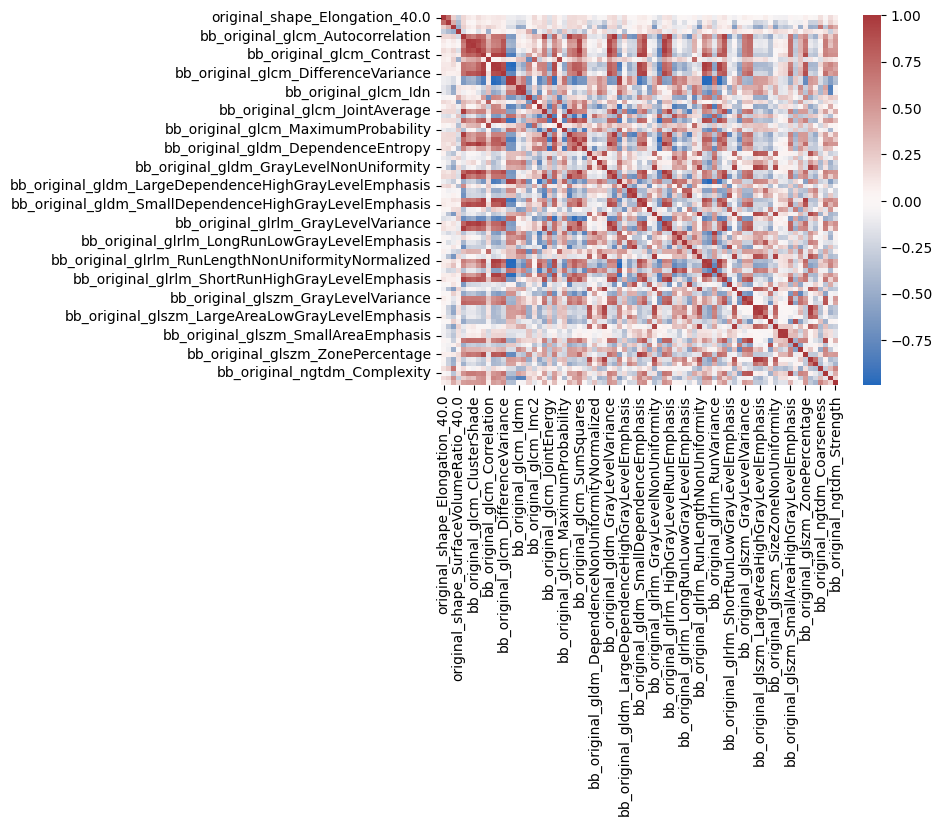

In [11]:
sns.heatmap(T1_40_train_data.corr(), cmap='vlag')

In [12]:
shape_target_train = data_train[['Shape.1']]
margins_target_train = data_train[['Margins (MR)']]
shape_target_eval = target_eval[['mr_mass_shp.factor']]
margins_target_eval = target_eval[['mr_mass_mrg.factor']]

In [13]:
label_encoder = LabelEncoder()
shape_target_train['Shape.1']= label_encoder.fit_transform(shape_target_train['Shape.1']) 
shape_target_eval['mr_mass_shp.factor']= label_encoder.transform(shape_target_eval['mr_mass_shp.factor'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
shape_target_train.loc[shape_target_train['Shape.1']==2, 'Shape.1'] = 1
shape_target_eval.loc[shape_target_eval['mr_mass_shp.factor']==2, 'mr_mass_shp.factor'] = 1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
scaler_T1_40 = StandardScaler()
scaled_train_data_T1_40 = pd.DataFrame(scaler_T1_40.fit_transform(T1_40_train_data), columns=T1_40_train_data.columns)

In [16]:
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

In [17]:
# Extract and sort feature coefficients
def get_feature_coefs(regression_model, X):

    coef_dict = {}

    # Filter coefficients less than 0.01
    for coef, feat in zip(regression_model.coef_[0, :], X.columns):
        if abs(coef) >= 0.01:
            coef_dict[feat] = coef

    # Sort coefficients
    coef_dict = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}
    return coef_dict

In [18]:
# Generate bar colors based on if value is negative or positive
def get_bar_colors(values):

    color_vals = []
    for val in values:
        if val <= 0:
            color_vals.append('r')
        else:
            color_vals.append('g')

    return color_vals

 
# Visualize coefficients
def visualize_coefs(coef_dict):

    features = list(coef_dict.keys())
    values = list(coef_dict.values())
    y_pos = np.arange(len(features))
    color_vals = get_bar_colors(values)
    plt.rcdefaults()
    fig, ax = plt.subplots()
    ax.barh(y_pos, values, align='center', color=color_vals)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(features)

    # labels read top-to-bottom
    ax.invert_yaxis()  
    ax.set_xlabel('Feature Coefficients')
    ax.set_title('')

    plt.show()

In [19]:
rs = 123

# Grid search hyperparameters for a logistic regression model

def grid_search_lr(X_train, y_train, kfolds):
    params_grid = {
            'class_weight': [{0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}],
            'penalty': ["l1", "l2"],
            
            'C': np.arange(0.1, 3, 0.1)
                    }

    lr_model = LogisticRegression(random_state=rs, max_iter=1000, solver="liblinear")
    grid_search = GridSearchCV(estimator = lr_model,
                               param_grid = params_grid,
                               scoring='f1',
                               
                               cv = kfolds.split(X_train, y_train), 
                               verbose = 1)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

 

# Grid search hyperparameters for a random forest model

def grid_search_rf(X_train, y_train, kfolds):

    params_grid = {
            'max_depth': [2, 5, 10, 15, 20],
            'n_estimators': [5, 50, 100, 150, 200],
            'min_samples_split': [2, 5, 10, 15, 20],
            'max_features' : ['sqrt', 'log2', None],
            'class_weight': [None, {0:0.05, 1:0.95}, {0:0.1, 1:0.9}, {0:0.2, 1:0.8}, {0:0.3, 1:0.7}, {0:0.4, 1:0.6}, {0:0.5, 1:0.5}]

    }

    rf_model = RandomForestClassifier(random_state=rs)
    grid_search = GridSearchCV(estimator = rf_model,
                               param_grid = params_grid,
                               scoring='f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search

def grid_search_xgb(X_train, y_train, kfolds, sample_weight):

    params_grid = {
        'max_depth': range (2, 10, 1),
        'n_estimators': range(60, 220, 40),
        'learning_rate': [0.1, 0.01, 0.05]
    }

    boost_model = XGBClassifier(objective= 'binary:logistic',
                                nthread=4, 
                                scale_pos_weight = sample_weight,
                                random_state=rs)
    grid_search = GridSearchCV(estimator=boost_model,
                               param_grid=params_grid,
                               scoring = 'f1',
                               cv = kfolds.split(X_train, y_train),
                               n_jobs=50,
                               verbose=True)
    
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    return best_params, grid_search


    
def return_kfold_score(model, to_fit, target, metric, kfolds, name=None):
    score = cross_val_score(model, to_fit, target, scoring=metric, cv=kfolds).mean()
    if name is None:
        print(metric + ' ' + str(score))
    else:
        print(name + ' ' + str(score))
    return score

In [20]:
best_params_logreg_T1_40, grid_search_logreg_T1_40 = grid_search_lr(scaled_train_data_T1_40, shape_target_train.values.ravel(), skf)


Fitting 5 folds for each of 348 candidates, totalling 1740 fits


In [21]:
grid_search_logreg_T1_40.best_score_

0.5185645933014353

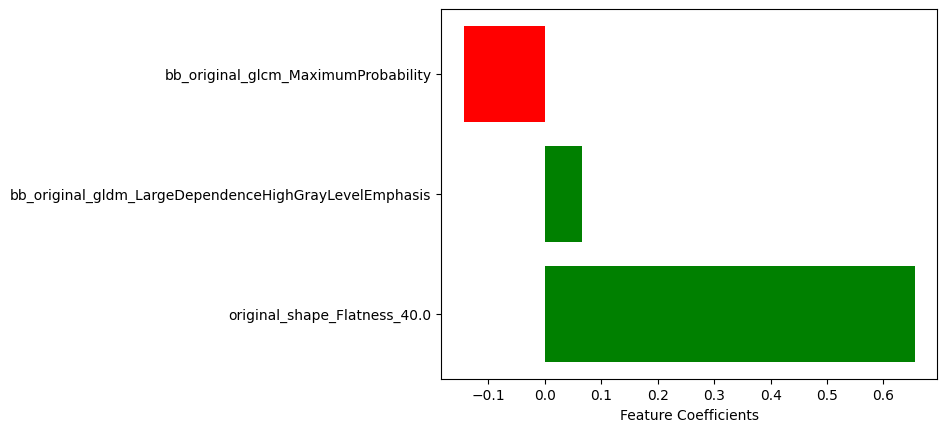

In [22]:
coef_dict = get_feature_coefs(grid_search_logreg_T1_40.best_estimator_, scaled_train_data_T1_40)
visualize_coefs(coef_dict)

In [23]:
background_values_T1_40 = shap.maskers.Independent(scaled_train_data_T1_40, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_logreg_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(scaled_train_data_T1_40)

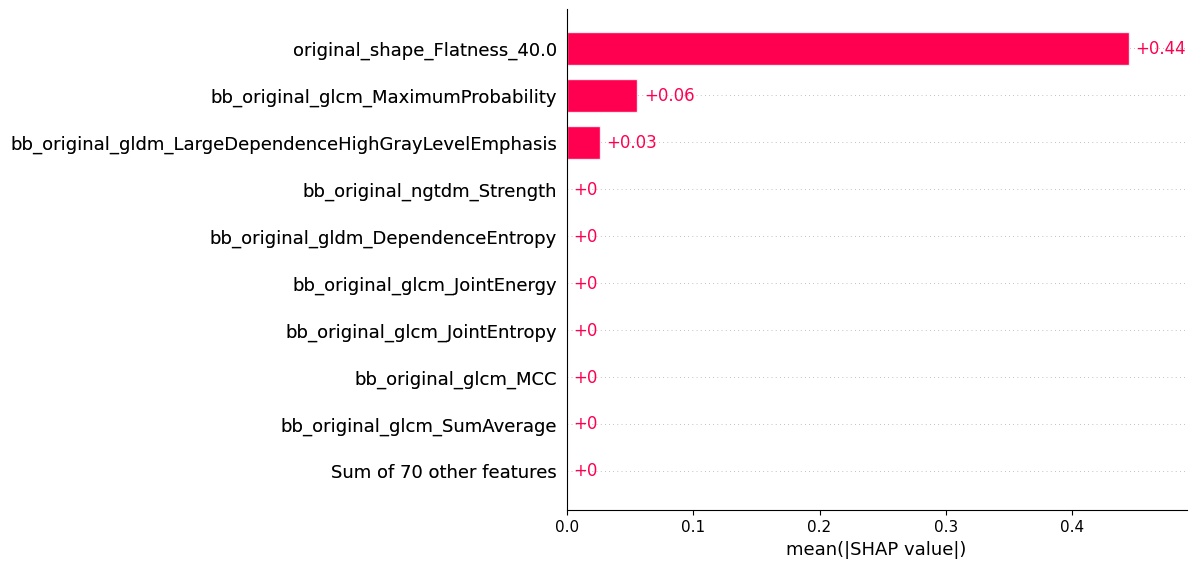

In [24]:
shap.plots.bar(shap_values_T1_40)

In [25]:
best_params_rf_T1_40, grid_search_randomforest_T1_40 = grid_search_rf(T1_40_train_data, shape_target_train.values.ravel(), skf)

Fitting 5 folds for each of 2625 candidates, totalling 13125 fits


In [26]:
grid_search_randomforest_T1_40.best_params_

{'class_weight': {0: 0.2, 1: 0.8},
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_split': 20,
 'n_estimators': 200}

Text(0.5, 1.0, 'Visualizing Feature Importances')

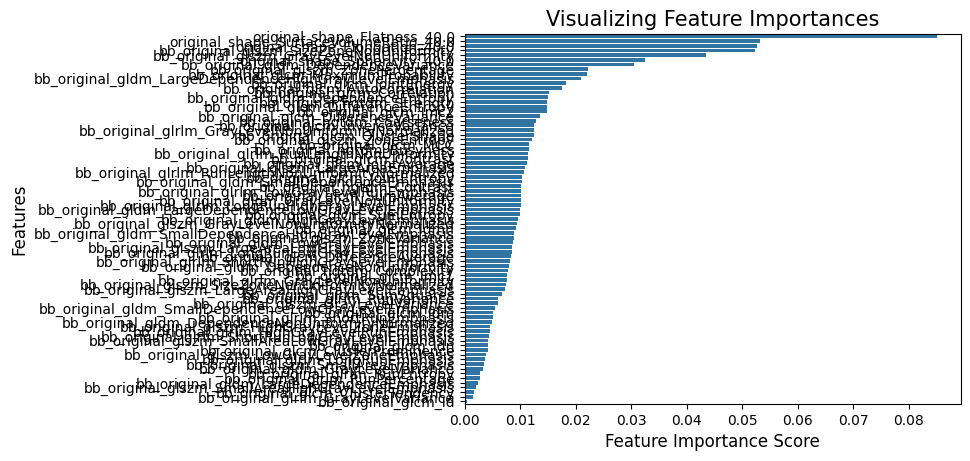

In [27]:
feature_imp = pd.Series(grid_search_randomforest_T1_40.best_estimator_.feature_importances_, index=T1_40_train_data.columns).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Visualizing Feature Importances", fontsize=15)

In [28]:
feature_imp[:35]

original_shape_Flatness_40.0                             0.085140
original_shape_SurfaceVolumeRatio_40.0                   0.053240
original_shape_Elongation_40.0                           0.052666
bb_original_glszm_SizeZoneNonUniformity                  0.052394
bb_original_glszm_GrayLevelNonUniformity                 0.043552
original_shape_Sphericity_40.0                           0.032505
bb_original_gldm_DependenceVariance                      0.030550
bb_original_glszm_ZonePercentage                         0.022227
bb_original_glcm_MaximumProbability                      0.022032
bb_original_gldm_LargeDependenceHighGrayLevelEmphasis    0.020922
bb_original_glcm_JointEnergy                             0.018252
bb_original_glcm_Autocorrelation                         0.017573
bb_original_glcm_Correlation                             0.015271
bb_original_gldm_DependenceEntropy                       0.014946
bb_original_ngtdm_Strength                               0.014872
bb_origina

In [29]:
feature_imp

original_shape_Flatness_40.0                        0.085140
original_shape_SurfaceVolumeRatio_40.0              0.053240
original_shape_Elongation_40.0                      0.052666
bb_original_glszm_SizeZoneNonUniformity             0.052394
bb_original_glszm_GrayLevelNonUniformity            0.043552
                                                      ...   
bb_original_gldm_LargeDependenceEmphasis            0.002357
bb_original_glszm_SmallAreaHighGrayLevelEmphasis    0.002024
bb_original_glcm_ClusterTendency                    0.001640
bb_original_glrlm_GrayLevelVariance                 0.001443
bb_original_glcm_Id                                 0.000445
Length: 79, dtype: float64

In [30]:
feature_imp[:35].index

Index(['original_shape_Flatness_40.0',
       'original_shape_SurfaceVolumeRatio_40.0',
       'original_shape_Elongation_40.0',
       'bb_original_glszm_SizeZoneNonUniformity',
       'bb_original_glszm_GrayLevelNonUniformity',
       'original_shape_Sphericity_40.0', 'bb_original_gldm_DependenceVariance',
       'bb_original_glszm_ZonePercentage',
       'bb_original_glcm_MaximumProbability',
       'bb_original_gldm_LargeDependenceHighGrayLevelEmphasis',
       'bb_original_glcm_JointEnergy', 'bb_original_glcm_Autocorrelation',
       'bb_original_glcm_Correlation', 'bb_original_gldm_DependenceEntropy',
       'bb_original_ngtdm_Strength', 'bb_original_glcm_DifferenceEntropy',
       'bb_original_glcm_Imc2', 'bb_original_glcm_DifferenceVariance',
       'bb_original_ngtdm_Coarseness', 'bb_original_glcm_InverseVariance',
       'bb_original_glrlm_GrayLevelNonUniformityNormalized',
       'bb_original_glcm_ClusterShade', 'bb_original_glszm_ZoneEntropy',
       'bb_original_glcm_MCC',

In [31]:
restricted_nb_of_features_train = T1_40_train_data[feature_imp[:35].index]
restricted_nb_of_features_eval = T1_40_eval_data[feature_imp[:35].index]

In [32]:
restricted_best_params_rf_T1_40, restricted_grid_search_randomforest_T1_40 = grid_search_rf(restricted_nb_of_features_train, shape_target_train.values.ravel(), skf)

Fitting 5 folds for each of 2625 candidates, totalling 13125 fits


In [33]:
background_values_T1_40 = shap.maskers.Independent(T1_40_train_data, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_randomforest_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(T1_40_train_data)

PermutationExplainer explainer: 137it [01:01,  1.86it/s]                         


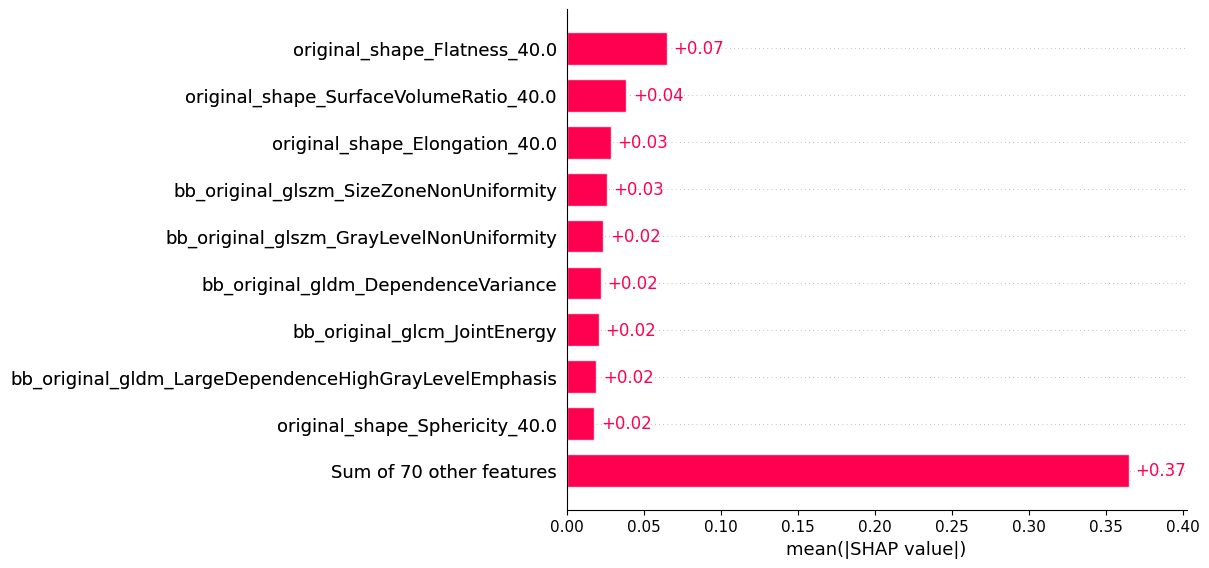

In [34]:
shap.plots.bar(shap_values_T1_40)

In [35]:
ratio = float(shape_target_train.value_counts()[0]) / shape_target_train.value_counts()[1]

In [36]:
best_params_xgb_T1_40, grid_search_xgboost_T1_40 = grid_search_xgb(T1_40_train_data, shape_target_train.values.ravel(), skf, ratio)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [37]:
background_values_T1_40 = shap.maskers.Independent(T1_40_train_data, max_samples=100)
# compute SHAP values
explainer_T1_40 = shap.Explainer(grid_search_xgboost_T1_40.predict, background_values_T1_40)
shap_values_T1_40 = explainer_T1_40(T1_40_train_data)

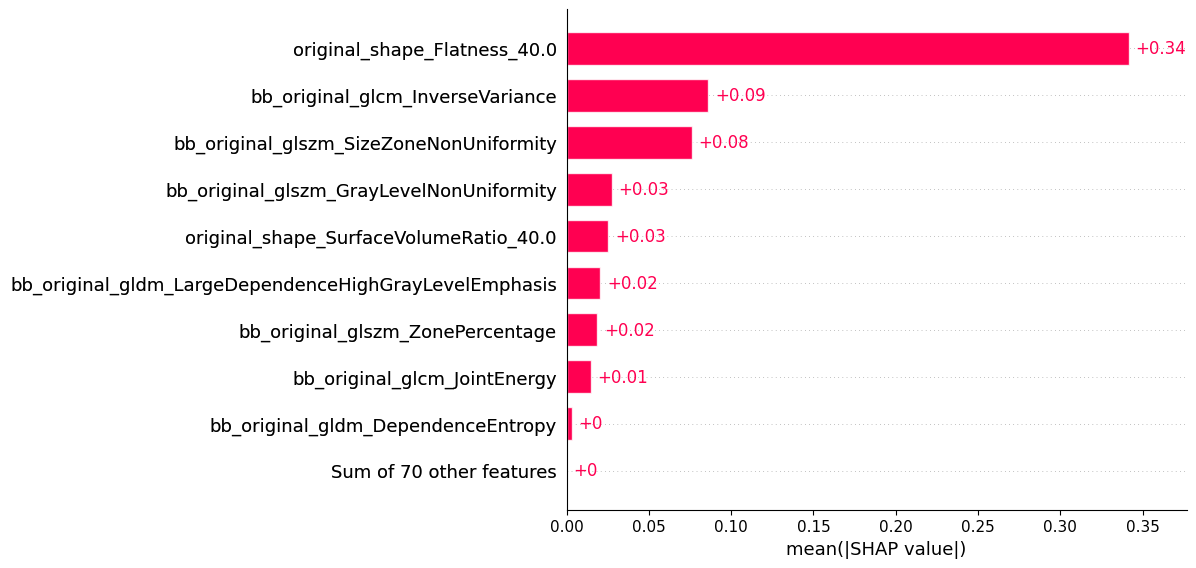

In [38]:
shap.plots.bar(shap_values_T1_40)

In [39]:
def compile_results(model, X, y, kfolds):
    auc = return_kfold_score(model, X, y, 'roc_auc', kfolds)
    balanced_accuracy = return_kfold_score(model, X, y, 'balanced_accuracy', kfolds)
    precision = return_kfold_score(model, X, y, 'precision', kfolds)
    recall = return_kfold_score(model, X, y, 'recall', kfolds)
    f1 = return_kfold_score(model, X, y, 'f1', kfolds)

    scoring = {
        'sensitivity': make_scorer(recall_score),
        'specificity': make_scorer(recall_score,pos_label=0)
    }
    specificity = return_kfold_score(model, X, y, scoring['specificity'], kfolds, 'specificity')
    sensitivity = return_kfold_score(model, X, y, scoring['sensitivity'], kfolds, 'sensitivity')
    youden_index = sensitivity + specificity - 1
    print('youden index: ' + str(youden_index))

In [40]:
print('Logistic Regression_T1_40')
compile_results(grid_search_logreg_T1_40.best_estimator_, scaled_train_data_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40')
compile_results(grid_search_randomforest_T1_40.best_estimator_, T1_40_train_data, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40')
compile_results(grid_search_xgboost_T1_40.best_estimator_, T1_40_train_data, shape_target_train.values.ravel(), skf)

Logistic Regression_T1_40
roc_auc 0.7334693877551022
balanced_accuracy 0.71
precision 0.37489226459814695
recall 0.8523809523809524
f1 0.5185645933014353
specificity 0.5676190476190477
sensitivity 0.8523809523809524
youden index: 0.41999999999999993

Random Forest_T1_40
roc_auc 0.6434240362811792
balanced_accuracy 0.6388095238095237
precision 0.44785714285714284
recall 0.4809523809523809
f1 0.4569114219114218
specificity 0.7966666666666666
sensitivity 0.4809523809523809
youden index: 0.27761904761904743

XG Boost_T1_40
roc_auc 0.648968253968254
balanced_accuracy 0.5985714285714285
precision 0.29154761904761906
recall 0.6380952380952382
f1 0.390527950310559
specificity 0.559047619047619
sensitivity 0.6380952380952382
youden index: 0.19714285714285706


In [ ]:
print('Logistic Regression_T1_40')
compile_results(grid_search_logreg_T1_40.best_estimator_, scaled_train_data_T1_40, shape_target_train.values.ravel(), skf)
print('')
print('Random Forest_T1_40')
compile_results(grid_search_randomforest_T1_40.best_estimator_, T1_40_train_data, shape_target_train.values.ravel(), skf)
print('')
print('XG Boost_T1_40')
compile_results(grid_search_xgboost_T1_40.best_estimator_, T1_40_train_data, shape_target_train.values.ravel(), skf)

In [41]:
print('Random Forest_T1_40')
compile_results(restricted_grid_search_randomforest_T1_40.best_estimator_, restricted_nb_of_features_train, shape_target_train.values.ravel(), skf)

Random Forest_T1_40


roc_auc 0.6838548752834467
balanced_accuracy 0.6680952380952381
precision 0.5942857142857143
recall 0.4428571428571428
f1 0.4991341991341991
specificity 0.8933333333333333
sensitivity 0.4428571428571428
youden index: 0.33619047619047615


In [42]:
def compute_pred(model, X_test):
    return model.predict(X_test)

LogisticRegression(C=0.30000000000000004, class_weight={0: 0.2, 1: 0.8},
                   max_iter=1000, penalty='l1', random_state=123,
                   solver='liblinear')
sensitivity: 0.8461538461538461
specificity: 0.40540540540540543
youden_index: 0.2515592515592515
balanced_accuracy: 0.6257796257796258
roc_auc: 0.6257796257796258
precision: 0.3333333333333333
recall: 0.8461538461538461
              precision    recall  f1-score   support

           0       0.88      0.41      0.56        37
           1       0.33      0.85      0.48        13

    accuracy                           0.52        50
   macro avg       0.61      0.63      0.52        50
weighted avg       0.74      0.52      0.54        50

RandomForestClassifier(class_weight={0: 0.2, 1: 0.8}, max_depth=5,
                       min_samples_split=20, n_estimators=200,
                       random_state=123)
sensitivity: 0.3076923076923077
specificity: 0.918918918918919
youden_index: 0.2266112266112268
balance

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)
sensitivity: 0.46153846153846156
specificity: 0.5945945945945946
youden_index: 0.05613305613305619
balanced_accuracy: 0.5280665280665281
roc_auc: 0.528066528066528
precision: 0.2857142857142857
recall: 0.46153846153846156
              precision    recall

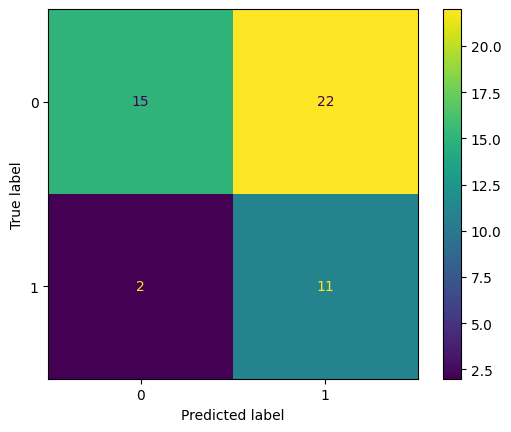

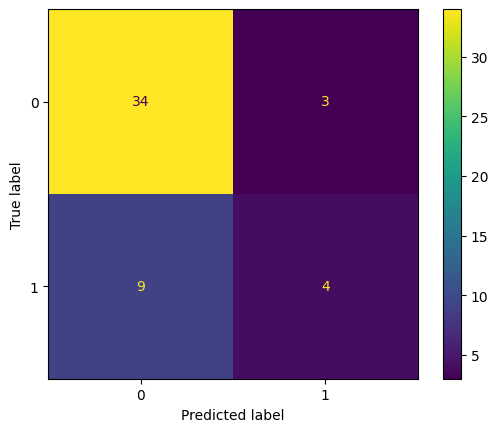

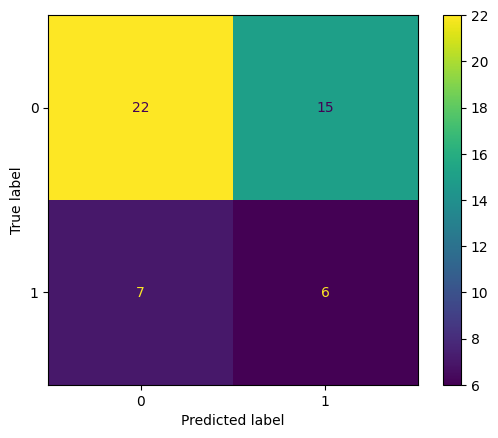

In [43]:
for model in [grid_search_logreg_T1_40.best_estimator_, grid_search_randomforest_T1_40.best_estimator_, grid_search_xgboost_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(T1_40_eval_data), columns=T1_40_eval_data.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, shape_target_eval)))
        
    else:
        y_pred = compute_pred(model, T1_40_eval_data)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, T1_40_eval_data, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, T1_40_eval_data, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, T1_40_eval_data, shape_target_eval)+ scoring['sensitivity'](model, T1_40_eval_data, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, T1_40_eval_data, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, T1_40_eval_data, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, T1_40_eval_data, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, T1_40_eval_data, shape_target_eval)))

    print(classification_report(shape_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7}, max_depth=5,
                       min_samples_split=20, n_estimators=50, random_state=123)
sensitivity: 0.23076923076923078
specificity: 0.918918918918919
youden_index: 0.1496881496881497
balanced_accuracy: 0.5748440748440748
roc_auc: 0.5748440748440748
precision: 0.5
recall: 0.23076923076923078
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        37
           1       0.50      0.23      0.32        13

    accuracy                           0.74        50
   macro avg       0.64      0.57      0.58        50
weighted avg       0.70      0.74      0.70        50



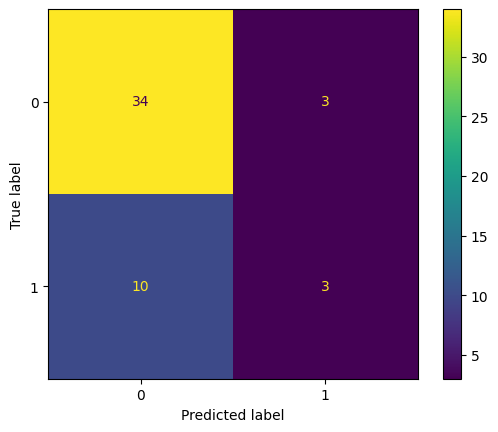

In [44]:
for model in [restricted_grid_search_randomforest_T1_40.best_estimator_]:
    scoring = {
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'precision_recall_f': make_scorer(precision_recall_fscore_support)
    }
    if model == grid_search_logreg_T1_40.best_estimator_:
        scaled_eval_features = pd.DataFrame(scaler_T1_40.transform(T1_40_eval_data), columns=T1_40_eval_data.columns)
        y_pred = compute_pred(model, scaled_eval_features)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, scaled_eval_features, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, scaled_eval_features, shape_target_eval)+ scoring['sensitivity'](model, scaled_eval_features, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, scaled_eval_features, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, scaled_eval_features, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, scaled_eval_features, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, scaled_eval_features, shape_target_eval)))
        
    else:
        y_pred = compute_pred(model, restricted_nb_of_features_eval)
        print(model)
        print('sensitivity: ' + str(scoring['sensitivity'](model, restricted_nb_of_features_eval, shape_target_eval)))
        print('specificity: ' + str(scoring['specificity'](model, restricted_nb_of_features_eval, shape_target_eval)))
        print('youden_index: ' + str(scoring['specificity'](model, restricted_nb_of_features_eval, shape_target_eval)+ scoring['sensitivity'](model, restricted_nb_of_features_eval, shape_target_eval) - 1))
        print('balanced_accuracy: ' + str(scoring['balanced_accuracy'](model, restricted_nb_of_features_eval, shape_target_eval)))
        print('roc_auc: ' + str(scoring['roc_auc'](model, restricted_nb_of_features_eval, shape_target_eval)))
        print('precision: ' + str(scoring['precision'](model, restricted_nb_of_features_eval, shape_target_eval)))
        print('recall: ' + str(scoring['recall'](model, restricted_nb_of_features_eval, shape_target_eval)))

    print(classification_report(shape_target_eval.values.ravel(), y_pred))
    cm = confusion_matrix(shape_target_eval.values.ravel(), y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)
    disp.plot()
    